# Обучение модели с учителем

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений. «В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий. Задача разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Для решения задачи необходимо провести предобработку данных, изучить данные. Изучить влияние признаков между собой и на целевой признак. 

Для поиска лучшей модели использовать пайплайн, в котором перебрать модели и гиперпараметры.

Произвести сегментацию покупателей. Дополнительно провести анализ выбранных групп.

## Загрузка данных

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install matplotlib==3.5.2 -q 
!pip install phik  -q
!pip install shap==0.47.2 -q

  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [33 lines of output]
  Traceback (most recent call last):
    File "D:\Anaconda\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
      main()
    File "D:\Anaconda\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "D:\Anaconda\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 112, in get_requires_for_build_wheel
      backend = _build_backend()
                ^^^^^^^^^^^^^^^^
    File "D:\Anaconda\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 77, in _build_backend
      obj = import_module(mod_path)
            ^^^^^^^^^^^^^^^^^^^^^^^
    File "D:\Anaconda\Lib\importlib\__init__.py",

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import numpy as np
import shap

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score 
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score #, recall_score, accuracy_score

from sklearn.linear_model import LogisticRegression  #, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

In [3]:
# import warnings
# warnings.filterwarnings('ignore')  # окключить предупреждения

In [4]:
market_file = r'C:\Users\Владелец\Desktop\Учеба\git_hab_project\datasets\market_file.csv'
market_money = r'C:\Users\Владелец\Desktop\Учеба\git_hab_project\datasets\market_money.csv'
market_time = r'C:\Users\Владелец\Desktop\Учеба\git_hab_project\datasets\market_time.csv'
money = r'C:\Users\Владелец\Desktop\Учеба\git_hab_project\datasets\money.csv'
df_market_file = pd.read_csv(market_file)
df_market_money= pd.read_csv(market_money)
df_market_time = pd.read_csv(market_time)
df_money = pd.read_csv(money, sep =';', decimal = ',')

In [5]:
df_market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [6]:
df_market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [7]:
df_market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [8]:
df_money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


## Предобработка данных

### Проверка данных market_file

In [9]:
df_market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [10]:
df_market_file.rename(columns={'Тип сервиса' : 'Тип_сервиса',
                           'Покупательская активность': 'Покуп_актив',
                           'Разрешить сообщать' : 'Согл_уведомл'
                           },inplace=True)


In [11]:
def сhecking_values (df):  # функция для просмотра значений 
    columns = df.columns
    for i, column in enumerate(columns):
        if df[column].dtypes=='object':
            display(f'Уникальные значения {column}:{df[column].unique()}')
        else:   
            if df[column].nunique()>20:
                display(f'Кол-во значений {column}:{df[column].nunique()}')
            else:
                display(f'Уникальные значения {column}:{sorted(df[column].unique())}')            

In [12]:
сhecking_values(df_market_file)

'Кол-во значений id:1300'

"Уникальные значения Покуп_актив:['Снизилась' 'Прежний уровень']"

"Уникальные значения Тип_сервиса:['премиум' 'стандартт' 'стандарт']"

"Уникальные значения Согл_уведомл:['да' 'нет']"

'Кол-во значений Маркет_актив_6_мес:41'

'Уникальные значения Маркет_актив_тек_мес:[3, 4, 5]'

'Кол-во значений Длительность:658'

'Кол-во значений Акционные_покупки:42'

"Уникальные значения Популярная_категория:['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'\n 'Техника для красоты и здоровья' 'Кухонная посуда'\n 'Мелкая бытовая техника и электроника']"

'Уникальные значения Средний_просмотр_категорий_за_визит:[1, 2, 3, 4, 5, 6]'

'Уникальные значения Неоплаченные_продукты_штук_квартал:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]'

'Уникальные значения Ошибка_сервиса:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]'

'Уникальные значения Страниц_за_визит:[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]'

В столбце Тип сервиса имеется неявный дубликат

In [13]:
df_market_file['Тип_сервиса'] = df_market_file['Тип_сервиса'].replace('стандартт','стандарт')
df_market_file['Тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [14]:
df_market_file.duplicated().sum()

0

In [15]:
df_market_file.isna().sum()

id                                     0
Покуп_актив                            0
Тип_сервиса                            0
Согл_уведомл                           0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

**Вывод**

Дубликатов и пропусков в датафрейме нет.

### Проверка данных marcet_money.

In [16]:
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [17]:
df_market_money['id'].nunique()

1300

In [18]:
df_market_money.duplicated().sum()

0

In [19]:
df_market_money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

**Вывод** 

Дубликатов и пропусков нет. Количество id -1300. Имеется информация о покупке за последние три месяца. Поэтому число строк 3900.

### Проверка данных market_time

In [20]:
df_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [21]:
df_market_time.duplicated().sum()

0

In [22]:
df_market_time.isna().sum()

id        0
Период    0
минут     0
dtype: int64

In [23]:
df_market_time.nunique()

id        1300
Период       2
минут       20
dtype: int64

In [24]:
сhecking_values(df_market_time)

'Кол-во значений id:1300'

"Уникальные значения Период:['текущий_месяц' 'предыдцщий_месяц']"

'Уникальные значения минут:[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]'

In [25]:
df_market_time['Период'] = df_market_time['Период'].replace('предыдцщий_месяц','предыдущий_месяц')
df_market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

**Вывод** 

Дубликатов и пропусков нет. Количество id -1300. Количество строк 2600. Но нет информации о предпредыдущем месяце.

### Проверка данных money

In [26]:
df_money.duplicated().sum()

0

In [27]:
df_money.isna().sum()

id         0
Прибыль    0
dtype: int64

In [28]:
df_money['id'].nunique()

1300

### Вывод

Проведена предобработка данных Дубликатов и пропусков в датафреймах нет. В датафрейме marcet_money количество id -1300. Имеется информация о покупке за последние три месяца. Поэтому число строк 3900. В датафрейме market_time Количество id -1300. Количество строк 2600. Но нет информации о предпредыдущем месяце. В датафреме money кол-во id-1300


##  Исследовательский анализ данных

Согласно задания необходимо отобрать клиентов с покупательской способностью не менее трех месяцев. Для этого необходимо изучить данные датафреймов

Функция для построения 

In [29]:
def hist_bar (df):  # функция для построения гистограмм рапределений
    columns = df.columns.drop('id')
    sns.set_style("darkgrid")
    # plt.style.use('seaborn')
    fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(5, 20), layout="constrained") # более точное расст между подграф.
    for i, column in enumerate(columns):
        if df[column].dtypes=='object':
            df[column].value_counts().plot(kind='bar', 
                 title = f'Распределение значений категориального признака - {column}', 
                         xlabel=f'Значения - {column}', 
                         ylabel='Количество',
                 ax=axes[i])
            
        else:
            if df[column].nunique()>20:
                df[column].plot(kind='hist', ax=axes[i], bins=20,
                    title=f'Гистограмма распределения числового признака -{column}')
                plt.xlabel(f'Значения - {column}')
                plt.ylabel('Количество')
                                            
                axes[i].axvline(x=df[column].mean(), color='r', label='Среднее значение',
                        linestyle='-', linewidth=1, )  # верт. линия со средним значением
               
            else:
                df[column].value_counts().sort_index().plot(kind='bar', 
                                    ax=axes[i],
                                    title=f'Гистограмма распределения дискретный признака -{column}',
                                    xlabel=f'Дискретный признак - {column}',
                                    ylabel='Количество')
                         
    #plt.tight_layout()
    plt.show()  

In [30]:
def plot_box (df):  # функция для построения "ящика с усами"
    columns = [col for col in df.select_dtypes(include='number').columns 
                if col != 'id' and df[col].nunique() > 20]
    sns.set_style("whitegrid")
    ##plt.style.use('seaborn')
    fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 5))
    for i, column in enumerate(columns):
        df[column].plot(kind='box',vert=False, ax=axes[i], title=(f'Ящик с усами для - {column}'))
    plt.tight_layout()
    plt.show()    
        
       

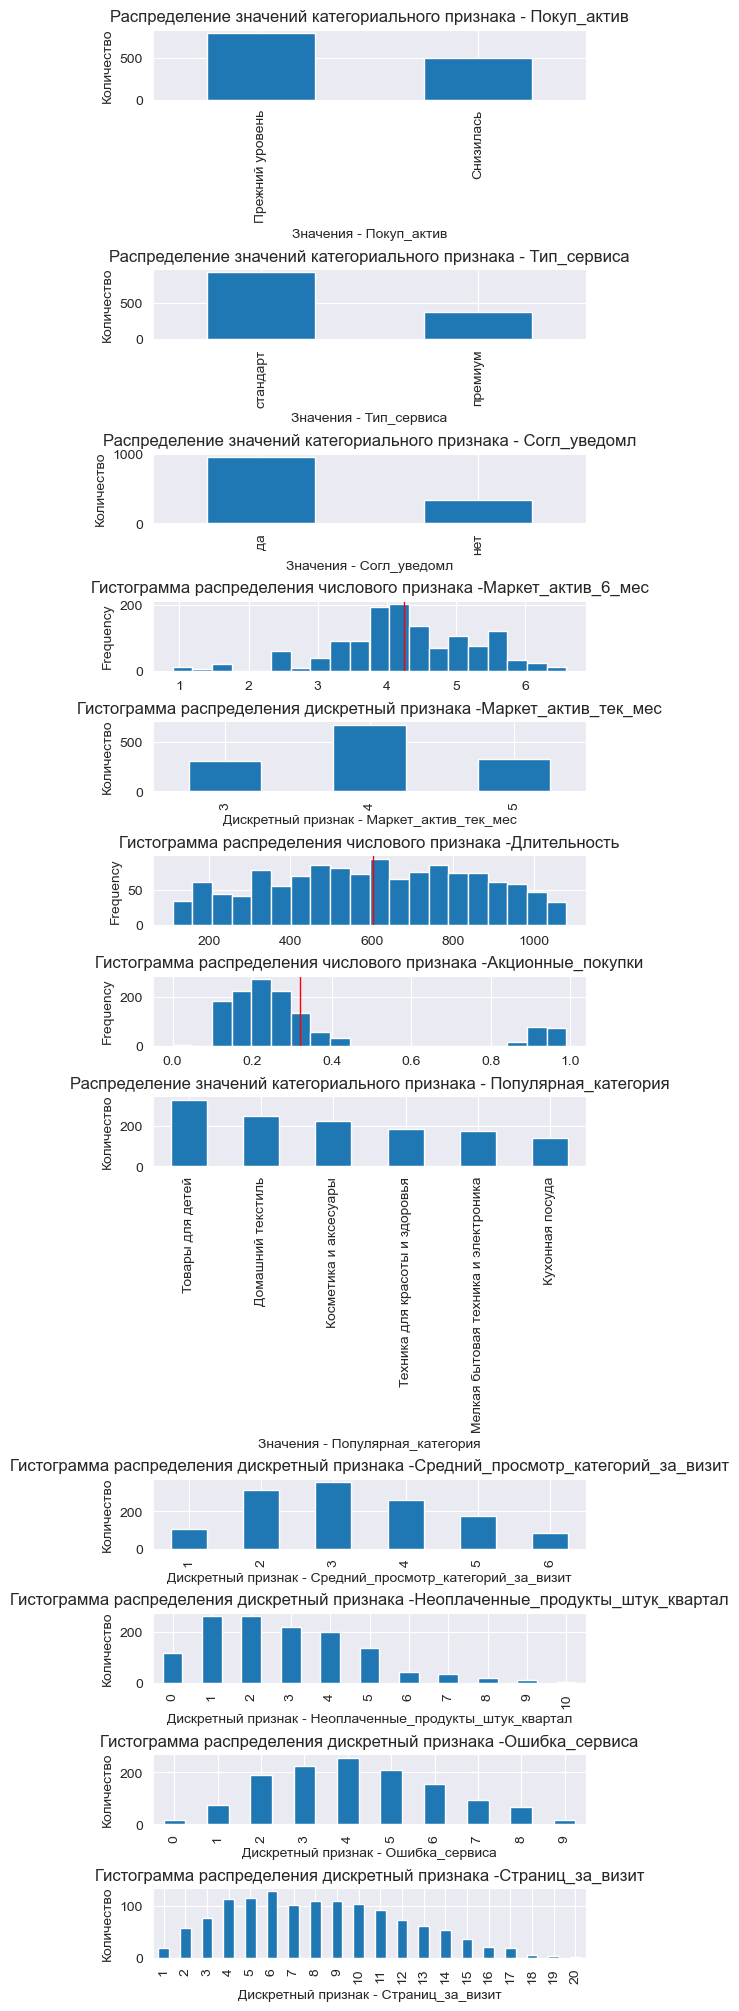

In [31]:
hist_bar(df_market_file)

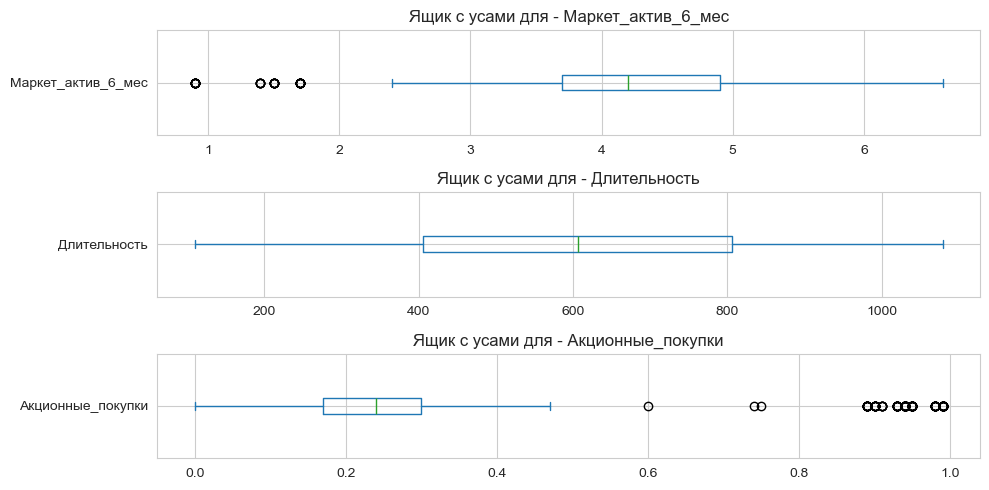

In [32]:
plot_box(df_market_file)

### marcet_money

In [33]:
df_market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


##### Данные по выручке за три месяца

In [34]:
df_market_money_1 = df_market_money.pivot_table(index='id',columns='Период')
df_market_money_1.reset_index(inplace=True)
df_market_money_1.columns = ['id',	'месяц_2',	'месяц_1',	'месяц_3']
df_market_money_1 = df_market_money_1.query('месяц_2 !=0 and месяц_1 !=0 and месяц_3 != 0')
df_market_money_1.shape

(1297, 4)

In [35]:
df_market_money_1.describe()

,id,месяц_2,месяц_1,месяц_3
count,1297.000000,1297.000000,1297.000000,1297.000000
mean,215998.986893,4948.339630,4836.367772,5316.449268
std,374.578554,701.228571,333.438742,2942.469139
min,215349.000000,2890.000000,4098.000000,2758.700000
25%,215675.000000,4498.500000,4585.000000,4706.600000
50%,215999.000000,5005.500000,4812.000000,5180.300000
75%,216323.000000,5409.000000,5055.000000,5761.300000
max,216647.000000,6869.500000,5663.000000,106862.200000


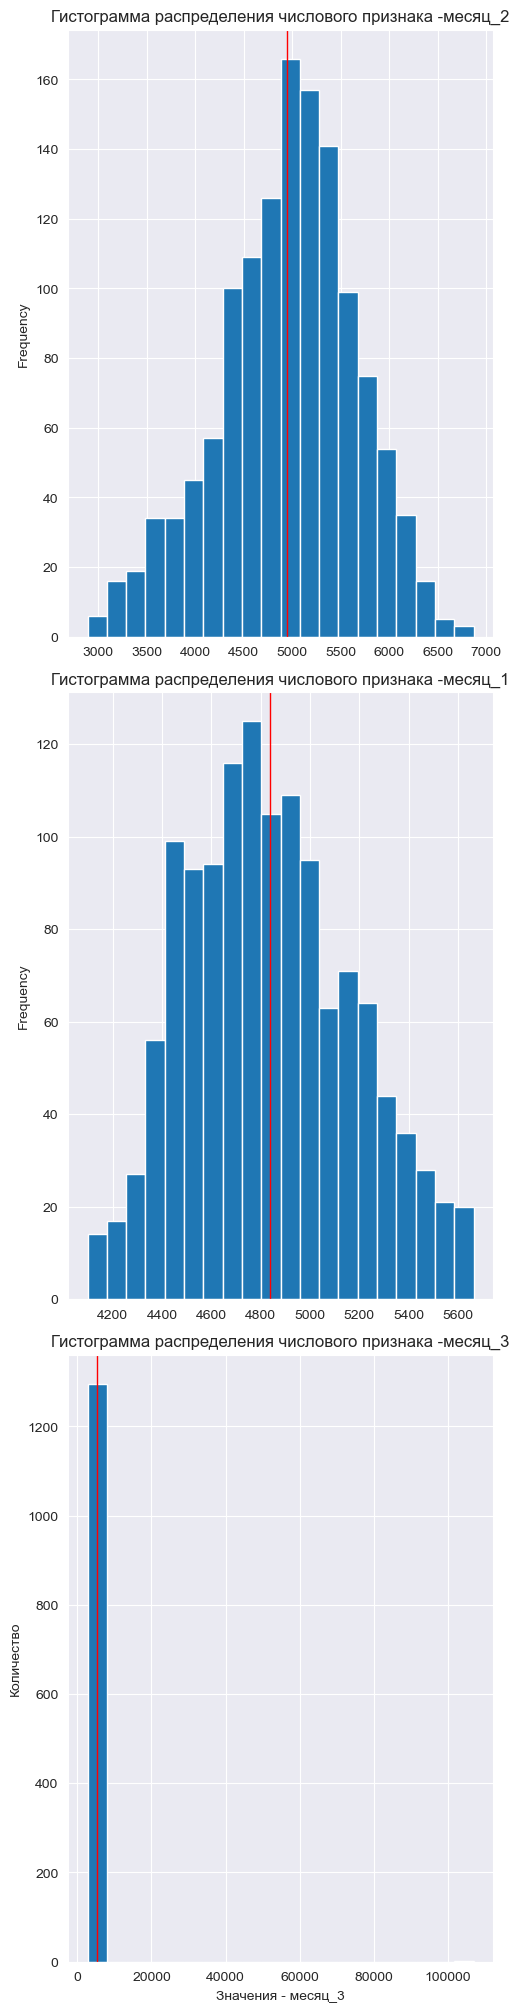

In [36]:
hist_bar(df_market_money_1)

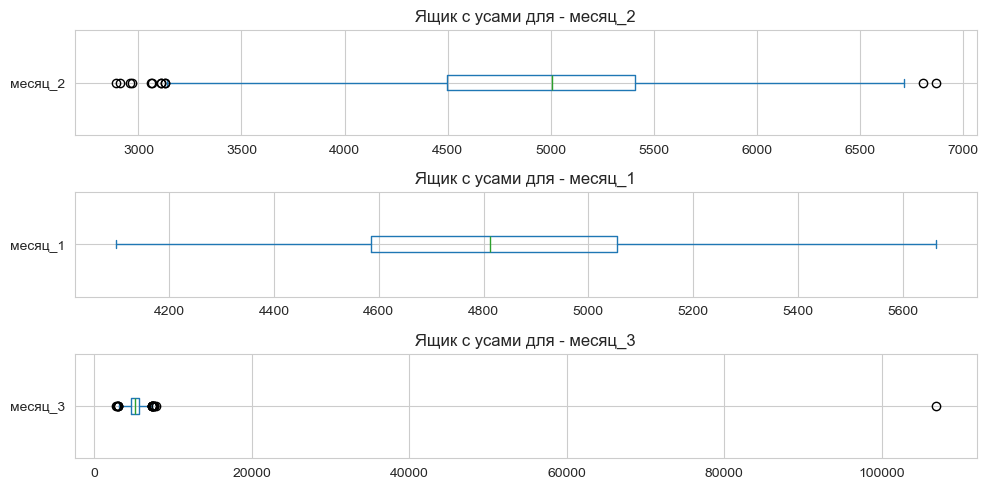

In [37]:
plot_box(df_market_money_1)

In [38]:
#df_market_money_1.query('Выручка==106862.200000')
df_market_money_1 = df_market_money_1[df_market_money_1['месяц_3'] != 106862.2]
df_market_money_1.shape

(1296, 4)

**Вывод** 

Проверены данные marcet_money. Отобраны активные пользователи, которые совершали покупки каждый месяц. Удален выброс по выручки со значением в 6 раз больше остальных значений.   

### market_time

In [39]:
df_market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


In [40]:
df_market_time_active = df_market_time.pivot_table(index='id', columns='Период', aggfunc='sum')
df_market_time_active.reset_index(inplace=True)
df_market_time_active.columns=['id', 'Пред_месяц', 'Текущ_месяц']
df_market_time_active.head()

,id,Пред_месяц,Текущ_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


In [41]:
df_market_time_active = df_market_time_active.query('Пред_месяц!=0 and Текущ_месяц!=0')
df_market_time_active.shape

(1300, 3)

In [42]:
df_market_time_active.describe()

,id,Пред_месяц,Текущ_месяц
count,1300.000000,1300.000000,1300.000000
mean,215997.500000,13.467692,13.204615
std,375.421985,3.932029,4.220589
min,215348.000000,5.000000,4.000000
25%,215672.750000,11.000000,10.000000
50%,215997.500000,13.000000,13.000000
75%,216322.250000,17.000000,16.000000
max,216647.000000,23.000000,23.000000


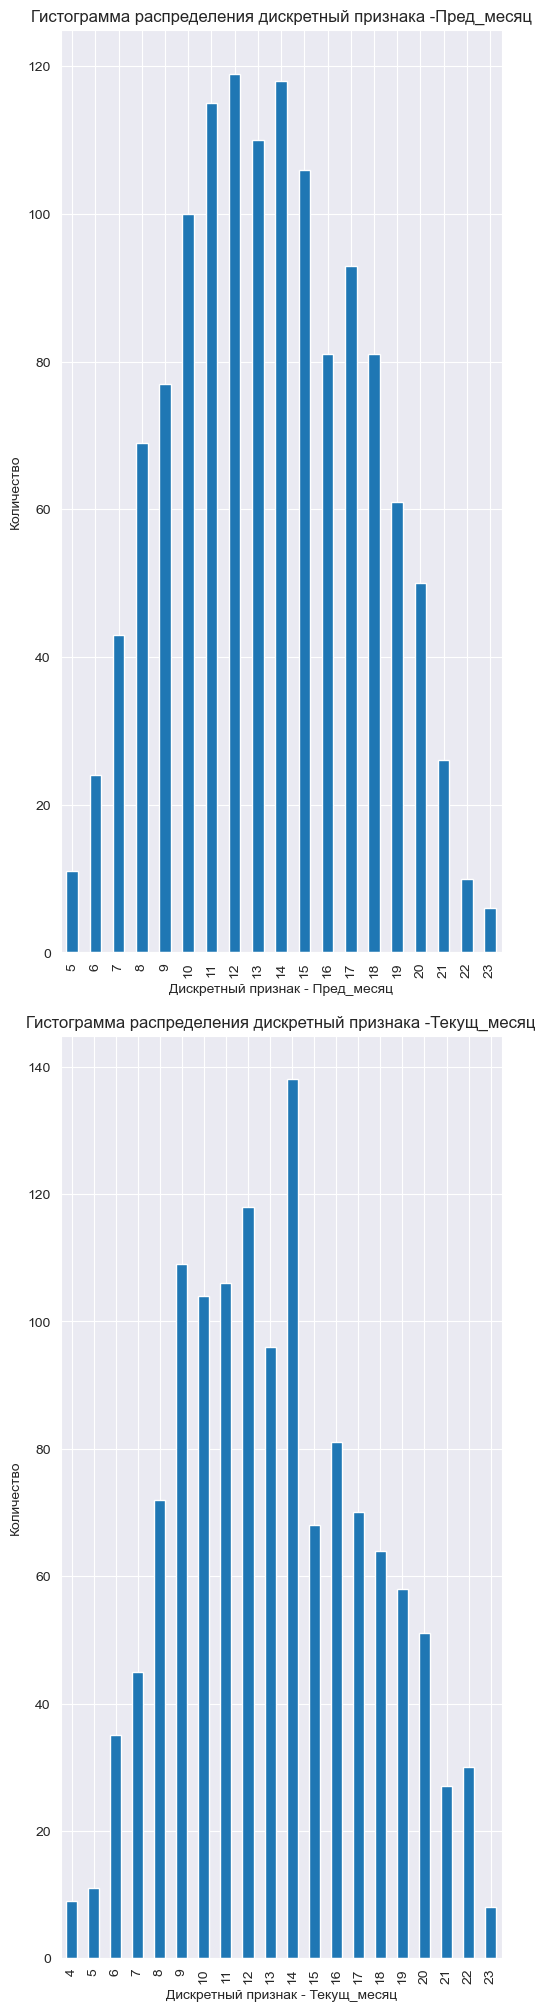

In [43]:
hist_bar(df_market_time_active)


**Вывод**

Значения market_time распределены в пределах 4-23 минут

### money

In [44]:
df_money['Прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

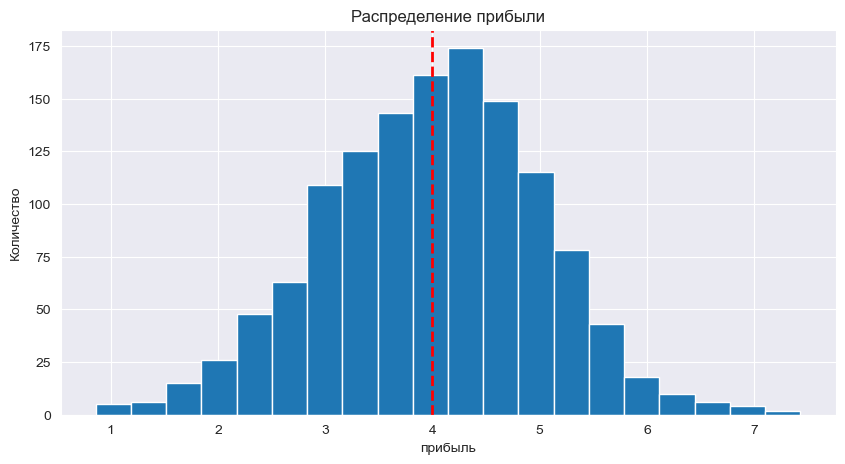

In [45]:
df_money['Прибыль'].plot(kind='hist', bins=20,figsize=(10,5) )
plt.title('Распределение прибыли')
plt.xlabel('прибыль')
plt.ylabel('Количество')
plt.axvline(x=df_money['Прибыль'].mean(), color='r', linestyle='--', linewidth=2);

In [46]:
df_money.query('id ==215380')

,id,Прибыль
32,215380,3.88


In [47]:
df_market_file.query('id ==215380')

,id,Покуп_актив,Тип_сервиса,Согл_уведомл,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7


### Вывод

Отобраны активные пользователи, которые совершали покупки каждый месяц. Удален выброс по выручки со значением в 6 раз больше остальных значений. Значения  в market_time распределены в пределах 4-23 минут

## Объединение таблиц

df_market_money_1 = df_market_money.pivot_table(index='id',columns='Период')
df_market_money_1.reset_index(inplace=True)
df_market_money_1.columns = ['id',	'2_месяц',	'1_месяц',	'3_месяц']
df_market_money_1.head()

In [48]:

df_general = df_market_file.merge(df_market_money_1, on ='id')#, how='right')
df_general.shape

(1296, 16)

In [49]:
df_general.head()

,id,Покуп_актив,Тип_сервиса,Согл_уведомл,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,месяц_2,месяц_1,месяц_3
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5


In [50]:
df_general = df_general.merge(df_market_time_active, on ='id', how='left')
df_general.shape

(1296, 18)

In [51]:
df_general.head()

,id,Покуп_актив,Тип_сервиса,Согл_уведомл,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,месяц_2,месяц_1,месяц_3,Пред_месяц,Текущ_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [52]:
df_total=df_general.drop('id',axis=1)
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покуп_актив                          1296 non-null   object 
 1   Тип_сервиса                          1296 non-null   object 
 2   Согл_уведомл                         1296 non-null   object 
 3   Маркет_актив_6_мес                   1296 non-null   float64
 4   Маркет_актив_тек_мес                 1296 non-null   int64  
 5   Длительность                         1296 non-null   int64  
 6   Акционные_покупки                    1296 non-null   float64
 7   Популярная_категория                 1296 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  Ошибка_сервиса                       1296 non-null   int64  
 11  Страниц_за_визит              

**Вывод**

Осуществлено объединение датафремов, информация по периодам выведена в отдельные столбцы. Получилось 17 колонок, 1300 строк

## Корреляционный анализ

In [53]:
try: 
    correlation_matrix = df_total.corr(method='spearman')  # корреляция Спирмана

    plt.figure(figsize=(12, 6))
    sns.heatmap(correlation_matrix, annot=True)
    plt.show()
except:
    pass


In [54]:
def df_num_col(df):
    num_col = [col for col in df.select_dtypes(include='number').columns 
                if col != 'id' and df[col].nunique() > 20]
    return num_col    

In [55]:
num_col =df_num_col(df_total)

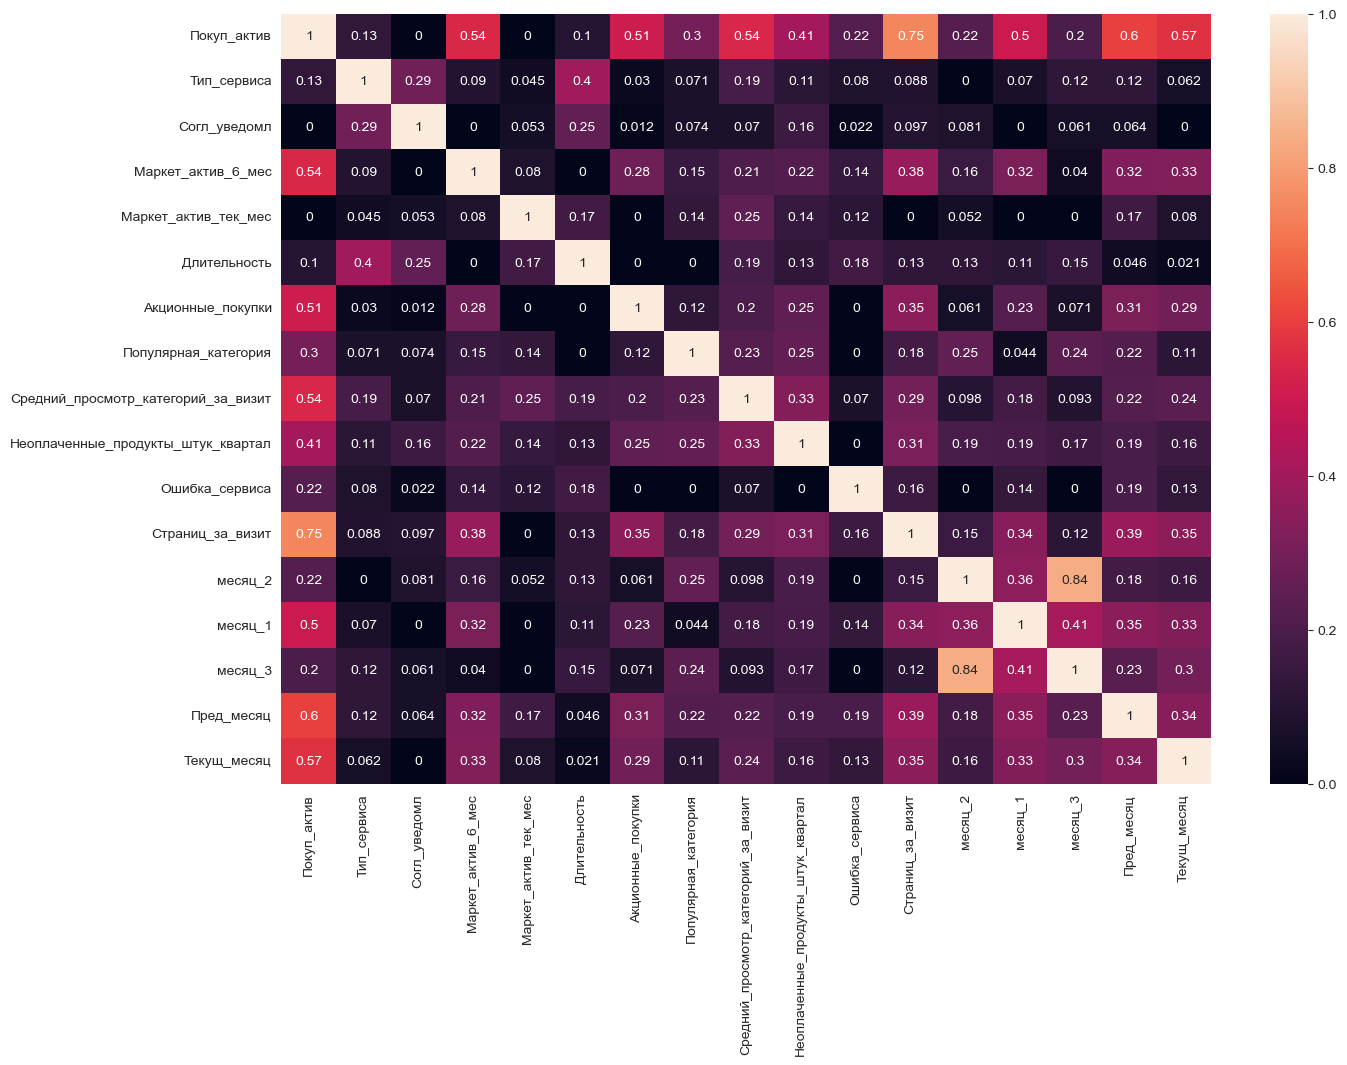

In [56]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_total.phik_matrix(interval_cols=num_col), annot=True) 
plt.show()

Удаление входных признаков, имеющих коэффициент корреляции 0 с целевым признаком. Кроме того признак "длительность" имеет высокую корреляцию с другими признаками.

In [57]:
df_total = df_total.drop(['Согл_уведомл','Маркет_актив_тек_мес', 'Длительность'], axis=1)
df_total.columns

Index(['Покуп_актив', 'Тип_сервиса', 'Маркет_актив_6_мес', 'Акционные_покупки',
       'Популярная_категория', 'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'месяц_2', 'месяц_1', 'месяц_3', 'Пред_месяц',
       'Текущ_месяц'],
      dtype='object')

Чтобы избавиться от мультиколлинеарности 2 и 3 месяца активности, объеденим данные по выручке за 2,3 месяц. Также добавим 1 месяц.

In [58]:
df_total['выручка'] = df_total['месяц_1']+df_total['месяц_2']+df_total['месяц_3']
df_total = df_total.drop(['месяц_1', 'месяц_2', 'месяц_3'],axis=1)

Построим еще раз матрицу корреляции

In [59]:
num_col =df_num_col(df_total)
display(num_col)

['Маркет_актив_6_мес', 'Акционные_покупки', 'выручка']

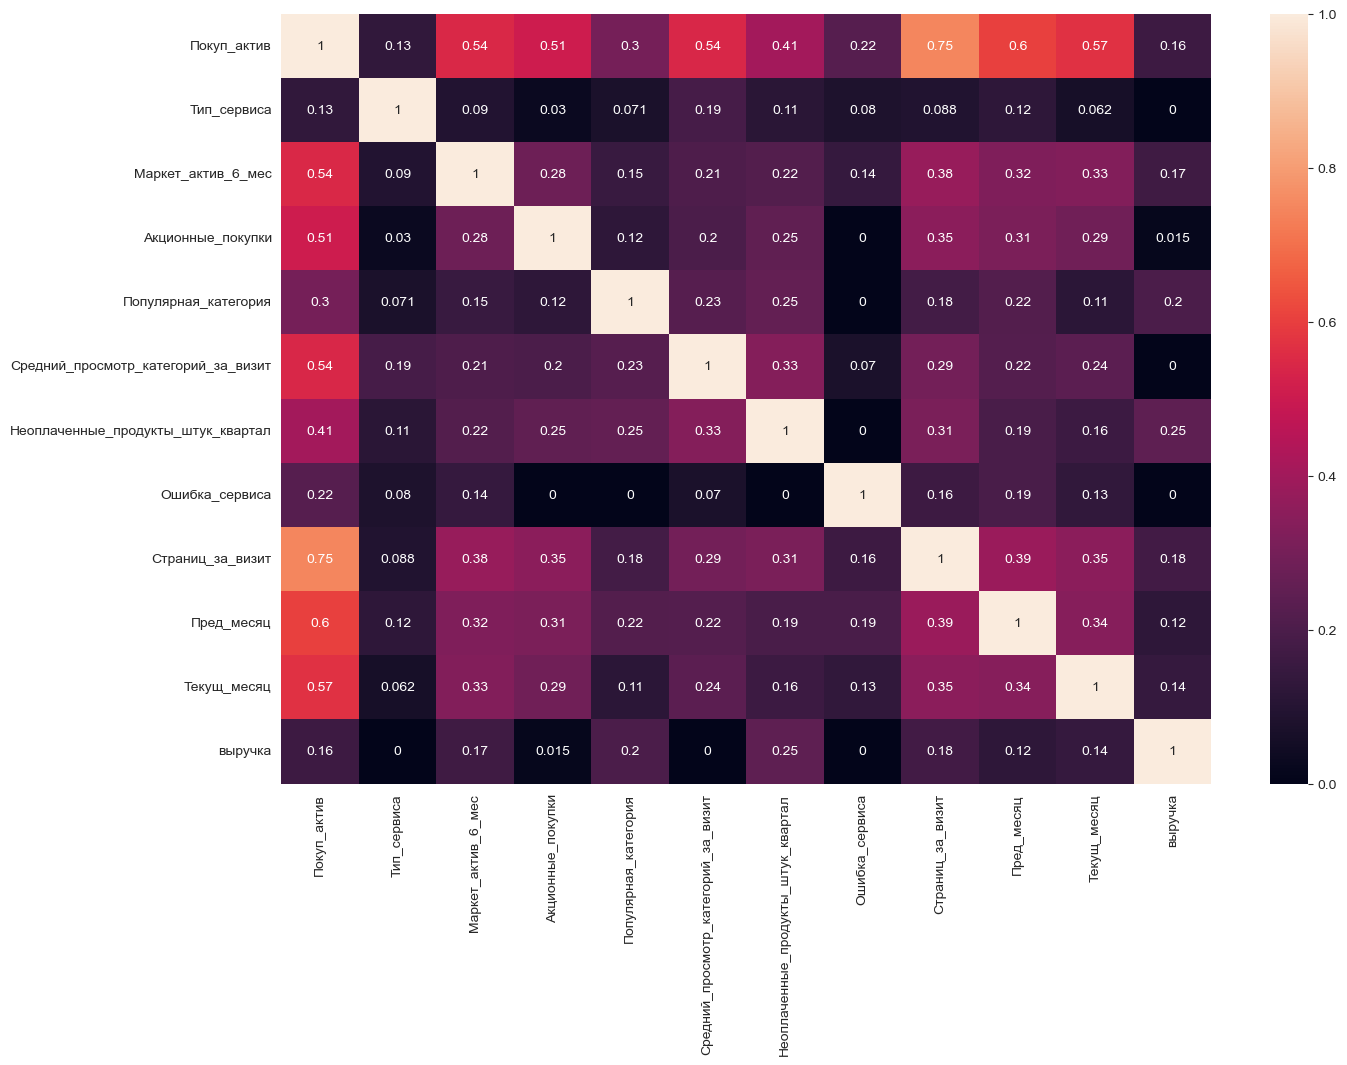

In [60]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_total.phik_matrix(interval_cols=num_col), annot=True); 

In [61]:
df_total.columns

Index(['Покуп_актив', 'Тип_сервиса', 'Маркет_актив_6_мес', 'Акционные_покупки',
       'Популярная_категория', 'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Пред_месяц', 'Текущ_месяц', 'выручка'],
      dtype='object')

**Вывод**


Исходя из матрицы корреляции, имеется зависимость между признаками - выручками в 2-м месяце и 3-м месяце, коээфициент 0.84.  Имеется мультиколлинеарность. Зависимость между признаком длительность и рядом других признаков. Мультиколлинеарность убрана - суммурированием выручки за 3 месяца, удалением признака -'длительность' имеющий 0 коэффициент с целевым признаком. Также удалены признаки с 0 зависимостью 'Согл_уведомл','Маркет_актив_тек_мес'.

Зависимость целевого признака - Покупательская активность с входными признаками также имеется.
маркет активность за 6 месяцев -0.61, Акционные покупки - 0.5, средний просмотр категорий за визит - 0.54, неоплаченные продукты 0.41, страниц за визит - 0.75, время пред. месяца - 0.6, текущ месяца - 0.58.

## Использование пайплайнов

### Подготовка данных

In [62]:
сhecking_values(df_total)

"Уникальные значения Покуп_актив:['Снизилась' 'Прежний уровень']"

"Уникальные значения Тип_сервиса:['премиум' 'стандарт']"

'Кол-во значений Маркет_актив_6_мес:41'

'Кол-во значений Акционные_покупки:41'

"Уникальные значения Популярная_категория:['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'\n 'Кухонная посуда' 'Техника для красоты и здоровья'\n 'Мелкая бытовая техника и электроника']"

'Уникальные значения Средний_просмотр_категорий_за_визит:[1, 2, 3, 4, 5, 6]'

'Уникальные значения Неоплаченные_продукты_штук_квартал:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]'

'Уникальные значения Ошибка_сервиса:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]'

'Уникальные значения Страниц_за_визит:[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]'

'Уникальные значения Пред_месяц:[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]'

'Уникальные значения Текущ_месяц:[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]'

'Кол-во значений выручка:1265'

In [63]:
df_total['Покуп_актив'].value_counts()

Покуп_актив
Прежний уровень    802
Снизилась          494
Name: count, dtype: int64

Для оценки качества модели необходимо применить метроику ROC-AUC, так как: 

1. необходимо оценить качество модели вне зависимости от порога вероятности. 

2. Имеется дисбаланс классов целевого признака

#### Деление на выборки

In [64]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    df_total.drop(['Покуп_актив'], axis=1),
    df_total['Покуп_актив'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_total['Покуп_актив']) # стратификация выборки по значению целевого признака

X_train.shape, X_test.shape

# создаём списки с названиями признаков
ohe_columns = ['Популярная_категория']
ord_columns = ['Тип_сервиса']
#num_columns = ['Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки', 'выручка']
num_columns = num_col

In [65]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покуп_актив                          1296 non-null   object 
 1   Тип_сервиса                          1296 non-null   object 
 2   Маркет_актив_6_мес                   1296 non-null   float64
 3   Акционные_покупки                    1296 non-null   float64
 4   Популярная_категория                 1296 non-null   object 
 5   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 6   Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 7   Ошибка_сервиса                       1296 non-null   int64  
 8   Страниц_за_визит                     1296 non-null   int64  
 9   Пред_месяц                           1296 non-null   int64  
 10  Текущ_месяц                          1296 non-null   int64  
 11  выручка                       

#### Кодирование целевого признака

In [66]:
# создайте экземпляр класса LabelEncoder для кодирования целевого признака
label_encoder = LabelEncoder()

# обучите модель и трансформируйте тренировочную выборку 
y_train = label_encoder.fit_transform(y_train)

# трансформируем тестовую выборку
y_test = label_encoder.transform(y_test)

#### Подготовка пайплайна

##### Добавление OHE-кодирования в пайплайн

In [67]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore') #, sparse=False)
        )
    ]
) 


##### Добаваление Ordinal-кодирования в пайплайн.

In [68]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['премиум', 'стандарт'], 
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 


##### Объединение операции по подготовке данных. 

In [69]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)
 # Проверка правильности кодирования    

##### Итоговый пайплан

In [70]:
# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [71]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(),'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(),'passthrough']   
    },

    # словарь для модели LogisticRegression()
   # {
    #    'models': [LogisticRegression(
    #        random_state=RANDOM_STATE, 
    #        solver='liblinear', 
            # solver='saga', 
    #        penalty='l1'
    #    )],
        # 'models__penalty': ['l1', 'l2', 'elasticnet'],
    #    'models__C': range(2, 5),
    #    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(),'passthrough']  
  # },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],  # probability=True для метрики ROC-AUC 
        #'models__kernel': ['poly', 'rbf'],
        'models__degree': range(3,5),
        #'models__C': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }

]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_iter=10,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

display('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
display(f'Метрика лучшей модели на кросс-валидации:, {randomized_search.best_score_:.4f}')

'Лучшая модель и её параметры:\n\n'

D:\Anaconda\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['премиум',
                                                                                               'стандарт']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Тип_сервиса']),
                                                 ('num', RobustScaler(),
                                                  ['Маркет_актив_6_мес',
                                                   'Акционные_покупки',
                                                   'выручка'])])),
                ('models', SVC(probability=True, random_state=42))])

'Метрика лучшей модели на кросс-валидации:, 0.9051'

In [72]:
                             
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
display(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred):.4f}')

'Метрика ROC-AUC на тестовой выборке: 0.9003'

Проверяем модель на адекватность. Для этого необходимо сравнить полученную метрику с константой. В качестве константной модели  используется DummyClassifier

In [73]:
dummy_clf = DummyClassifier(strategy='stratified')  # каждая выбранная строка независима и одинаково распределена.
dummy_clf.fit(X_train, y_train)
dummy_clf.predict(X_test)


y_proba = dummy_clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
display(f' Метрика ROC-AUC - {roc_auc}')


result = cross_val_score(dummy_clf, X_train, y_train, cv=5, scoring='roc_auc')

display(f'Среднее значение ROC-AUC при кросс-валидации - {result.mean()}')

' Метрика ROC-AUC - 0.49993932775148653'

'Среднее значение ROC-AUC при кросс-валидации - 0.5242471148834784'

### Вывод.

Для подготовки данных, выбора гиперпараметров, выбора лучшей модели собран пайплан. Для оценки качества модели применина метрика ROC-AUC, так как имеется дисбаланс классов целевого признака. Лучшая модель выбрана рандомизированном поиском RandomizedSearchCV. 

Модель логистической регресии с гиперпараметрами С=3, с L1 регуляризацией, solver='liblinear'(с решателем для бинарной классификации). 
Метрика лучшей модели на тренировочной выборке: 0.9014
Метрика ROC-AUC на тестовой выборке: 0.9083

## Анализ важности признаков

### Оценка важности признаков для лучшей модели, построение графика важности признаков


In [ ]:
# Получаем лучший пайплайн
best_pipe = randomized_search.best_estimator_

# Извлекаем модель и препроцессор
model = best_pipe.named_steps['models']
preprocessor = best_pipe.named_steps['preprocessor']

# Получаем имена признаков после преобразования
feature_names = preprocessor.get_feature_names_out()

# Преобразуем данные
X_train_tf = preprocessor.transform(X_train)
X_test_tf = preprocessor.transform(X_test)

# Создаем explainer в зависимости от типа модели
if isinstance(model, LogisticRegression):
    # Для линейных моделей
    explainer = shap.LinearExplainer(
        model,
        X_train_tf,
        feature_names=feature_names
    )
elif isinstance(model, DecisionTreeClassifier):
    # для дерево решений
    explainer = shap.TreeExplainer(model)
else:
    # Для моделей KNN, SVM
    background = shap.sample(X_train_tf, 100)
    explainer = shap.KernelExplainer(model.predict_proba, background)

# Вычисляем SHAP значения
shap_values = explainer(X_test_tf) # новый способ explainer!!!

# Визуализация
plt.figure(figsize=(20, 10))
if isinstance(model, LogisticRegression):
    shap.summary_plot(shap_values, X_test_tf, feature_names=feature_names, show=False)
else:
    if isinstance(shap_values, list) and len(shap_values) == 2:
        # Бинарная классификация - используем значения для положительного класса
        shap.summary_plot(shap_values[1], X_test_tf, feature_names=feature_names, show=False)
    else:
        shap.summary_plot(shap_values, X_test_tf, feature_names=feature_names, show=False)
plt.title('Влияние признаков на модель', fontsize=16, pad=5, fontweight='bold')
plt.ylabel('Признаки модели', fontsize=12, fontweight='bold' )
plt.xlabel('влияние признака', fontweight='bold', fontsize=12)
plt.show()

  0%|          | 0/324 [00:00<?, ?it/s]

In [ ]:
shap.plots.bar(shap_values, max_display=17, show=False)
plt.title('Влияние признаков на модель', fontweight='bold', fontsize=16)
plt.ylabel('Признаки модели', fontweight='bold', fontsize=12)  
plt.xlabel('влияние признака', fontweight='bold', fontsize=12) 
plt.show()

In [ ]:
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefficients)  # Используем абсолютные значения коэффициентов
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
sns.set_style('white')
plt.figure(figsize=(12, 8))

# Создаем горизонтальную barplot
ax = sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance,
    palette='viridis',  # Приятная цветовая схема
    orient='h'
)
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.01,  # Отступ от столбца
             p.get_y() + p.get_height()/2.,  # Позиционирование по вертикали
             f'{width:.4f}',  # Форматирование числа
             ha='left', va='center')

# Настраиваем заголовки и подписи
plt.title('Важность признаков модели', fontsize=16, pad=20)
plt.xlabel('Абсолютное значение коэффициента', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

### Выводы о значимости признаков:

Анализ графиков shap. Признаки малозначимые для модели:

- Популярная категория Косметика и аксесуары;
- выручка
- товары для детей
- кухоная посуда

Высокая значимость:

- страниц за визит
- средний просмотр категорий за визит
- проведенное время на сайте в предыдущем месяце
- проведенное время на сайте в текущем месяце
- акционные покупки
- мелкая бытовая техника и электроника


Анализ графика важности признаков модели логистической регрессии наиболее важные признаки

- мелкая бытовая техника и электроника
- маркет актив 6 месяцев
- техника для красоты и здоровья
- средний просмотр категорий за визит
- акционные покупки

Малозначимые:
- ошибка сервиса, тип сервиса, косметика и аксесуары, тип сервиса

Исходя из полученных данных можно предположить, что увеличив предложения (маркет-актив), просмотров за визит, в категориях мелкая бытовая техника, техника для красоты и здоровья позволит не снижать покупательскую активность. 

## Сегментация покупателей


In [ ]:
X_test['y_pred']=y_test_pred
X_test.shape

In [ ]:
X_test['id'] = X_test.index.map(df_general['id'])  # добавление удаленного ранее id

In [ ]:
X_test = X_test.merge(df_money, how='left')
X_test.shape

### Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

In [ ]:
X_test.columns

Функция сравнения распределений датафрейма

In [ ]:
def compare_distributions(df1, df2, drop_column=[]):
    
    # Проверка идентичности столбцов
    if not df1.columns.drop(drop_column).equals(df2.columns.drop(drop_column)):
        raise ValueError("Датафреймы содержат разные столбцы")
    
    # Получаем общие столбцы (исключая ID)
    columns = df1.columns.drop(drop_column)
    n_cols = len(columns)
    
    # Настройка стиля и размера
    #plt.style.use('seaborn')
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(nrows=n_cols, ncols=1, 
                           figsize=(12, 4*n_cols),
                           constrained_layout=True)
    
    # Если только один столбец, преобразуем axes в массив
    if n_cols == 1:
        axes = [axes]
    
    for i, column in enumerate(columns):
        ax = axes[i]
        dtype1 = df1[column].dtype
        dtype2 = df2[column].dtype
        
        # Проверка совместимости типов
        if dtype1 != dtype2:
            ax.text(0.5, 0.5, 
                   f'Типы не совпадают: {dtype1} vs {dtype2}',
                   ha='center', va='center')
            ax.set_title(f'Признак {column} - несовместимые типы')
            continue
            
        # Категориальные признаки
        if dtype1 == 'object':
            # Объединяем данные для согласованных категорий
            combined = pd.concat([df1[column], df2[column]])
            cats = combined.unique()
            
            df1[column].value_counts().reindex(cats, fill_value=0)\
                .plot(kind='bar', ax=ax, alpha=0.6, color='blue', 
                     label='DF1', position=0)
            df2[column].value_counts().reindex(cats, fill_value=0)\
                .plot(kind='bar', ax=ax, alpha=0.6, color='red', 
                     label='DF2', position=1)
            
            ax.set_title(f'Категориальный признак: {column}')
            ax.legend()
            
        # Числовые признаки
        else:
            if df1[column].nunique() > 20 or df2[column].nunique() > 20:
                # Гистограммы для непрерывных признаков
                df1[column].plot(kind='hist', bins=20, ax=ax, 
                               alpha=0.6, color='blue', label='DF1')
                df2[column].plot(kind='hist', bins=20, ax=ax, 
                               alpha=0.6, color='red', label='DF2')
                
                # Линии средних
                ax.axvline(df1[column].mean(), color='darkblue', 
                          linestyle='--', label=f'Среднее DF1')
                ax.axvline(df2[column].mean(), color='darkred', 
                          linestyle='--', label=f'Среднее DF1')
                
                ax.set_title(f'Непрерывный признак: {column}')
                ax.legend()
            else:
                # Столбчатые диаграммы для дискретных признаков
                combined = pd.concat([df1[column], df2[column]])
                bins = np.arange(combined.min(), combined.max()+2)-0.5
                
                df1[column].plot(kind='hist', bins=bins, ax=ax, 
                               alpha=0.6, color='blue', label='DF1')
                df2[column].plot(kind='hist', bins=bins, ax=ax, 
                               alpha=0.6, color='red', label='DF2')
                
                ax.set_title(f'Дискретный признак: {column}')
                ax.legend()
                
        ax.set_xlabel('')
        #ax.grid(axis='y', alpha=0.3)
 
    plt.show()

Определим две группы

1. С высокой вероятностью снижения активности и высокой прибыльностью.
2. С низкой вероятностью снижения активности и высокой прибыльностью

In [ ]:
X_1 = X_test.query('y_pred < 0.5 and Прибыль>4')
X_2 = X_test.query('y_pred > 0.5 and Прибыль>4')

In [ ]:
compare_distributions(X_1, X_2, ['id','Прибыль','y_pred'])

Из анализа распредления значений видно, что группа с низкой вероятностью больше покупает товары для детей. Маркет активность у первой группы выше, чем группы с высокой вероятностью. Доля акционных покупок у обеих групп ниже 0.5. Группа с низкой вероятностью снижения активности больше средний просмотр за категорию, также больше страниц за визит.

**Предложение**

Увеличить маркетактивность пользователей, у которых высокая вероятность снижения активности. Предложить акции.

### Группа клиентов с максимальной долей покупок по акции высокой прибылью и высокой вероятностью снижения покупательской активности.

In [ ]:
X_3 = X_test.query('y_pred < 0.5 and Прибыль>4 and Акционные_покупки >0.5')
X_4 = X_test.query('y_pred > 0.5 and Прибыль>4 and Акционные_покупки >0.5')

In [ ]:
compare_distributions(X_3, X_4, ['id','Прибыль', 'Акционные_покупки','y_pred'])

Клиенты с максимальной долей покупок по акции высокой прибылью и высокой вероятностью снижения покупательской активности, получили низкую маркет активность. Популярная категория у данных клиентов - товары для детей, домашний текстиль. 

Среднее время просмотра 3 минуты и количество страниц за визит 4. 

**Предложение** Возможно данным клиентам необходимо размещать акции и скидки на первых страницах, категорий товаров. Возможно установить фильтрацию по умолчанию.

### Вывод
Для определения и понимания взаимосвязей признаков и прогнозных значений необходимо было провести сегментацию пользователей.

Выбраны две группы:
- Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

Из анализа распредления значений видно, что группа с низкой вероятностью больше покупает товары для детей. Маркет активность у первой группы выше, чем группы с высокой вероятностью. Доля акционных покупок у обеих групп ниже 0.5. Группа с низкой вероятностью снижения активности больше средний просмотр за категорию, также больше страниц за визит.

**Предложение**

Увеличить маркетактивность пользователей, у которых высокая вероятность снижения активности. Предложить акции.

- группа клиентов с максимальной долей покупок по акции высокой прибылью и высокой вероятностью снижения покупательской активности.
Клиенты с максимальной долей покупок по акции высокой прибылью и высокой вероятностью снижения покупательской активности, получили низкую маркет активность. Популярная категория у данных клиентов - товары для детей, домашний текстиль. 

Среднее время просмотра 3 минуты и количество страниц за визит 4. 

**Предложение** Возможно данным клиентам необходимо размещать акции и скидки на первых страницах, категорий товаров. Возможно установить фильтрацию по умолчанию.


## Общий вывод

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений. «В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий.

Разработано решение, которое позволило персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Проведена предобработка данных Дубликатов и пропусков в датафреймах нет. В датафрейме marcet_money количество id -1300. Имеется информация о покупке за последние три месяца. Поэтому число строк 3900. В датафрейме market_time Количество id -1300. Количество строк 2600. Но нет информации о предпредыдущем месяце. В датафреме money кол-во id-1300

Проведен исследовательский анализ - Исходя из анализа данных датафреймов изучено, в течении трех последних месяца все пользователи (id) осуществляли покупки. Посчитана выручка за три месяца из датафрейма marcet_time для определения активности пользователя, так как прибыль в датафреме money могла быть равна 0 (магазин мог продать товар по с 0 прибылью). Имеется одно значение выручки, в 6 раз больше остальных, в тоже время прибыль у данного id - 3.88

Осуществлено объединение датафремов, информация по периодам выведена в отдельные столбцы.


На основе матрицы корреляции, найдена зависимость между входными признаками. Мультиколлинеарность убрана - суммурированием выручки за 3 месяца.

Определены коэффициенты зависимостей целевого признака - Покупательская активность с входными признаками. Признаки имеющие коэффициент 0 удалены из датафрейма.

Для подготовки данных, выбора гиперпараметров, выбора лучшей модели собран пайплан. Для оценки качества модели применина метрика ROC-AUC, так как имеется дисбаланс классов целевого признака. Лучшая модель выбрана рандомизированном поиском RandomizedSearchCV.

Модель логистической регресии с гиперпараметрами С=3, с L1 регуляризацией, solver='liblinear'(с решателем для бинарной классификации). Метрика лучшей модели на тренировочной выборке: 0.9014 Метрика ROC-AUC на тестовой выборке: 0.9083


Значимость признаков
Построен график важности признаков логистической регрессии и анализ shap в обоих графиках наиболее важные признаки 

- средний просмотр категорий за визит
- акционные покупки
- мелкая бытовая техника и электроника
Предложение интернет магазину увеличить акционные покупки


ошибка сервиса, тип сервиса, косметика и аксесуары, тип сервиса
Исходя из полученных данных можно предположить, что увеличив предложения (маркет-актив), просмотров за визит, в категориях мелкая бытовая техника, техника для красоты и здоровья позволит не снижать покупательскую активность.

Для определения и понимания взаимосвязей признаков и прогнозных значений необходимо было провести сегментацию пользователей.
Для составления персонализированных предложений, проведена сегментация покупателей

Выбраны две группы:
- Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

Из анализа распредления значений видно, что группа с низкой вероятностью больше покупает товары для детей. Маркет активность у первой группы выше, чем группы с высокой вероятностью. Доля акционных покупок у обеих групп ниже 0.5. Группа с низкой вероятностью снижения активности больше средний просмотр за категорию, также больше страниц за визит.

**Предложение**

Увеличить маркетактивность пользователей, у которых высокая вероятность снижения активности. Предложить акции.

- группа клиентов с максимальной долей покупок по акции высокой прибылью и высокой вероятностью снижения покупательской активности.
Клиенты с максимальной долей покупок по акции высокой прибылью и высокой вероятностью снижения покупательской активности, получили низкую маркет активность. Популярная категория у данных клиентов - товары для детей, домашний текстиль. 

Среднее время просмотра 3 минуты и количество страниц за визит 4. 

**Предложение** Возможно данным клиентам необходимо размещать акции и скидки на первых страницах, категорий товаров. Возможно установить фильтрацию по умолчанию.

